Продолжение главы 7

В данном ноутбуке представлены:

1) Модуль Inception

2) Остаточные связи

3) Повторное использование экземпляров слоев

4) Модели как слои

# Inception
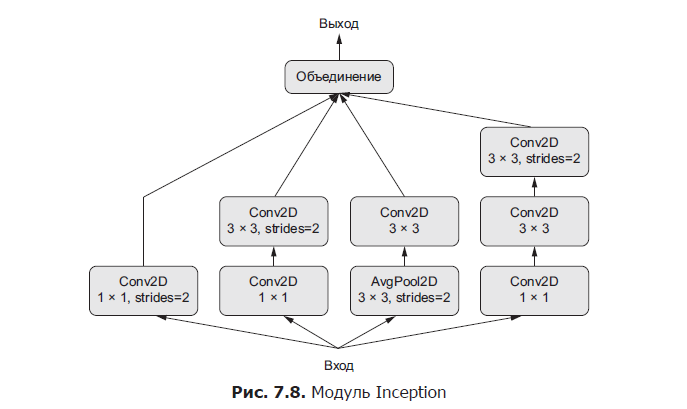

In [ ]:
# Свертка 1х1 извлекает признаки размером 1х1, что эквивалентно обычно обработке
# слоев Dense. Однако, такая свертка смешивает(в хорошем смысле) данные, послупающие 
# по трем каналом каждого пикселя, но не примешивает к этому информацию, находящуюся
# в соседних пикселях (так как просто их не трогает)

# это пример блока InceptionV3 (входной тензор предполагается 4ех мерный)
from keras import layers
# strides - шаги 
branch_a = layers.Conv2D(128, 1, activation='relu', strides=2)(x)

branch_b = layers.Conv2D(128, 1, activation='relu')(x)
branch_b = layers.Conv2D(128, 3, activation='relu', strides=2)(branch_b)

branch_c = layers.AveragePooling2D(3, strides=2)(x)
branch_c = layers.Conv2D(128, 3, activation='relu')(branch_c)

branch_d = layers.Conv2D(128, 1, activation='relu')(x)
branch_d = layers.Conv2D(128, 1, activation='relu')(branch_d)
branch_d = layers.Conv2D(128, 1, activation='relu', strides=2)(branch_d)

output = layers.concatenate(
    [branch_a, branch_b, branch_c, branch_d], axis=-1
)


In [ ]:
# Xception (Extreme Inception) отличается тем, что в ней сначала идет глубока свертка - depthwise convolution,
# которая обрабатывает КАЖДЫЙ канал отдельно, а уже потом идет поточечная свертка - pointwise convolution, как 
# в Inception, которая обрабатывает три канала сразу
# фактически - это крайняя стадия Inception, в которой канальные и пространственные признаки полностью разделены

# Остаточные связи

In [ ]:
# остаточная связь - это сложение вывода более раннего слоя с выводом
# более позднего слоя
# решает проблему затухания градиента и недостаточной репрезентативности

# вот так можно реализовать остаточную связь, если размеры карт признаком СОВПАДАЮТ
# (предполагается наличие 4ех мерного тензора x)
from keras import layers
x = ...
y = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
# вот ключевой момент - добваление входного тензора к выходным признакам
y = layers.add([y,x])

# вот так можно реализовать остаточную связь, если размеры карт признаком РАЗЛИЧАЮТСЯ
# (предполагается наличие 4ех мерного тензора x)
x = ...
y = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
y = layers.Conv2D(128, 3, activation='relu', padding='same')(y)
y = layers.MaxPooling2D(2, strides=2)(y)

residual = layers.Conv2D(128, 1, strides=2, padding='same')(x)

y = layers.add([y, residual])

# Повторное использование экземпляров слоев

In [ ]:
# при повторном использовании экземпляра класса, в разных местах 
# программы в нем будут использовать ОДНИ и те же веса

# создадим сеть для определения семантического сходства двух предложений
# предл. А зависит от предл. Б так же, как и предл. Б зависит от предл. А
# поэтому нет смысла тренировать две модели, чтобы их сравнивать
# лучше обрабатывать оба предложения одним слоем LSTM

from keras import layers
from keras import Input
from keras.models import Model

lstm = layers.LSTM(32)

left_input = Input(shape=(None,))
left_output = lstm(left_input)

# обращаясь к ранее созданному слою lstm, я использую его веса
right_input = Input(shape=(None,))
right_output = lstm(right_input)

merged = layers.concatenate([left_output, right_output], axis=-1)
# добавление классификатора
prediction = layers.Dense(1, activation='sigmoid')(merged)

model = Model([left_input, right_input], predictions)
model.compile(optimizer='rmsprop', loss='mse')
# в процессе обучения, веса слоя LSTM меняются при обработке обоих предложений
model.fit([left_data, right_data], targets)



# Модели как слои

In [ ]:
# о любой модели можно думать, как о большом слое
# output_1, output_2 = model(input_1, input_2)
# представим себе модель, которая будет обрабатывать видео с двух камер,
# расположенных на расстоянии пары дюймов

from keras import layers
from keras import applications
from keras impot Input

xception_base = applications.Xception(weights=None, include_top=False)

# входные изображения
input_1 = Input(shape=(250, 250, 1))
input_2 = Input(shape=(250, 250, 1))

# оба изображения обрабатываются одной моделью
# (а в предыдущем примере обработка была одним слоем - в этом разница)
features_1 = xception_base(input_1)
features_2 = xception_base(input_2)
merged_features = layers.concatenate([features_1, features_2], axis=-1)